In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

C:\Users\lol\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


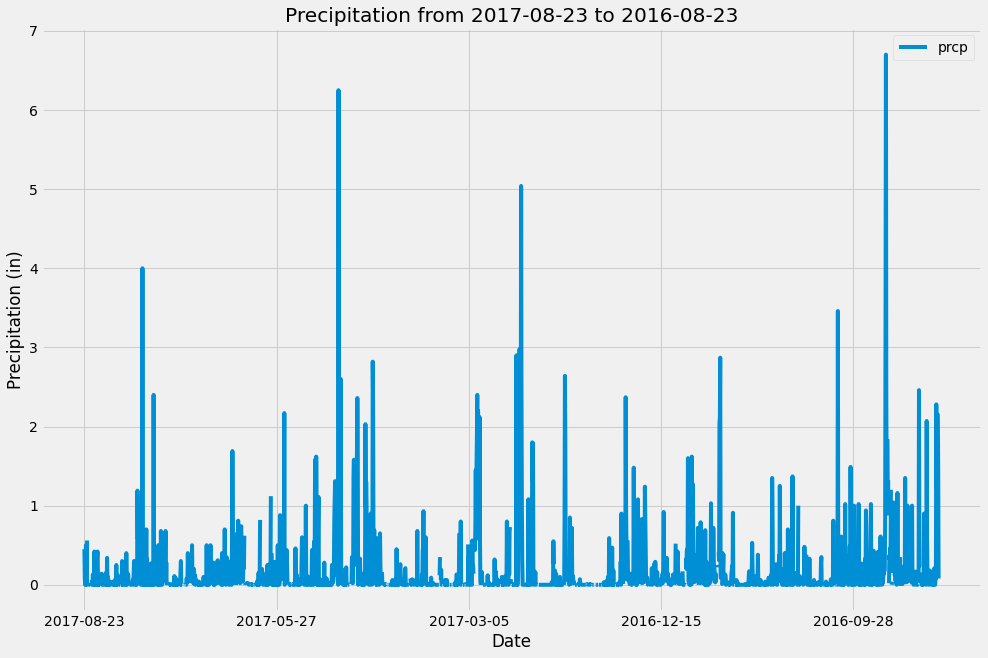

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Last day in Data Base ('2017-08-23')
last_day_data = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_day_data = last_day_data[0]

# Calculate the date 1 year ago from the last data point in the database
last_year_day = dt.date(2017,8,23) - dt.timedelta(days = 365)
last_year_day 

# Perform a query to retrieve the data and precipitation scores
prcp_year_ago = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > last_year_day).\
    order_by(Measurement.date).all()
prcp_year_ago

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_year_ago_df = pd.DataFrame(prcp_year_ago).set_index('date')
prcp_year_ago_df

# Sort the dataframe by date
prcp_year_ago_df = prcp_year_ago_df.sort_values(by='date', ascending=False)
prcp_year_ago_df

# Use Pandas Plotting with Matplotlib to plot the data
prcp_year_ago_df.plot(figsize = (15, 10));
plt.title(f"Precipitation from {last_day_data} to {last_year_day}");
plt.xlabel("Date");
plt.ylabel("Precipitation (in)");
plt.savefig("Images/Precipitation.png");


In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_year_ago_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
num_stations = session.query(func.count(Station.station)).all()
print(f"There are {num_stations[0][0]} stations.")

There are 9 stations.


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

# Most active station id
most_active_station = active_stations[0][0]

# Temp Measures
temp_measures = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()

# Print results
print(f"The most active station is: {most_active_station} and its temperature measures are: ") 
print(f"Low Temperature: {temp_measures[0][0]}, High Temperature: {temp_measures[0][1]}, Avg Temperature: {temp_measures[0][2]} ")


The most active station is: USC00519281 and its temperature measures are: 
Low Temperature: 54.0, High Temperature: 85.0, Avg Temperature: 71.66378066378067 


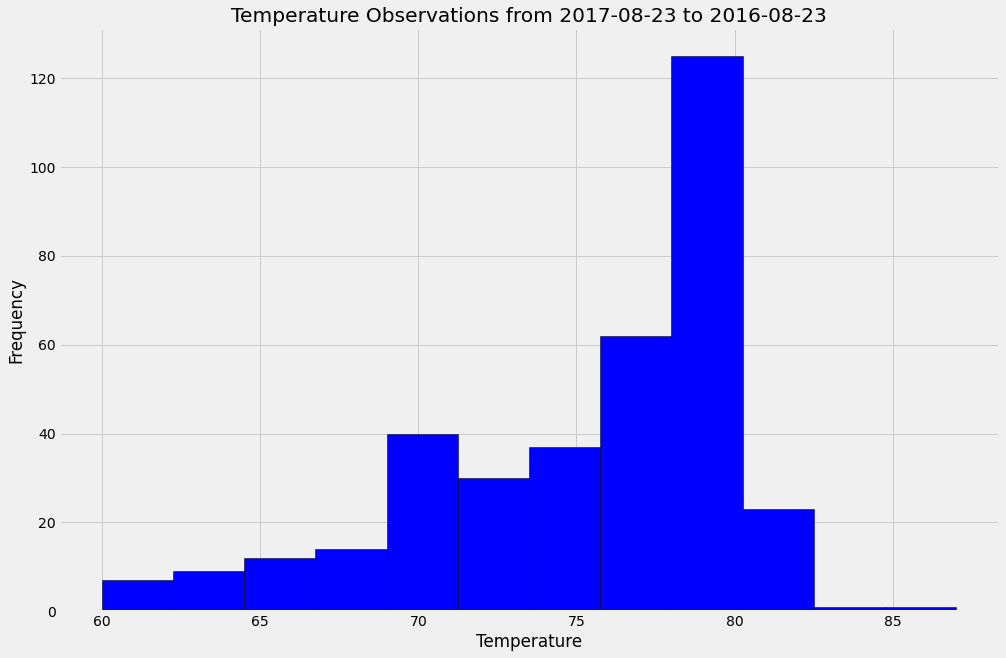

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Station with the highest number of temperature observations
max_tobs_id = session.query(Measurement.station, func.max(Measurement.tobs)).all()
max_tobs_id = max_tobs_id[0][0]

# Query the last 12 months of temperature observation data for this station
last_year_tobs = session.query(Measurement.tobs).\
    filter(Measurement.date >= last_year_day).\
    filter(Measurement.station == max_tobs_id).all()

# Save the query results as a Pandas DataFrame 
last_year_tobs_df = pd.DataFrame(last_year_tobs)

# Plot the results as a histogram
plt.figure(figsize=(15,10))
plt.hist(last_year_tobs_df, bins=12, color='blue', edgecolor='black');
plt.title(f"Temperature Observations from {last_day_data} to {last_year_day}")
plt.xlabel("Temperature")
plt.ylabel("Frequency")

# Save plot
plt.savefig("Images/Temp_Histograms.png")


## Bonus Challenge Assignment

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temps = calc_temps('2017-04-11', '2017-04-25')
trip_temps

[(67.0, 73.8, 83.0)]

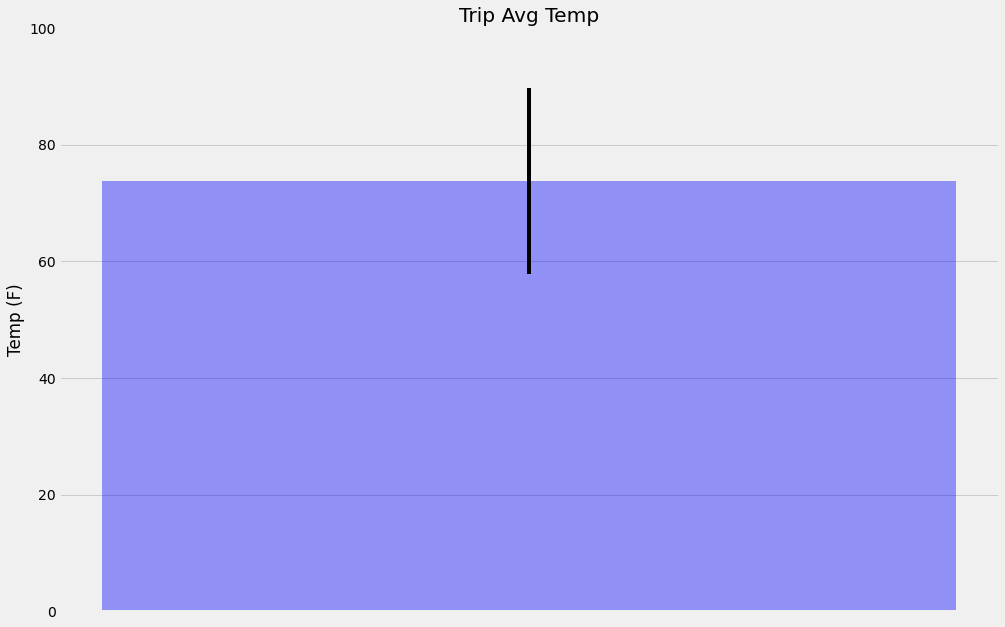

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

min_temp = trip_temps[0][0]
avg_temp = trip_temps[0][1]
max_temp = trip_temps[0][2]

plt.figure(figsize = (15,10))
plt.bar(1, avg_temp, yerr = [max_temp - min_temp], color = 'blue', alpha=0.4)

plt.title('Trip Avg Temp')
plt.ylim(0, 100)
plt.ylabel('Temp (F)')
plt.xticks([])

# Save Plot
plt.savefig("Images/Trip_Average_Temperature.png")



In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
initial_date = '2016-04-11'
final_date   = '2016-04-25'

measures = [func.sum(Measurement.prcp), Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation]

station_rainfall = session.query(*measures).\
                        filter(Measurement.station == Station.station).\
                        filter(Measurement.date >= initial_date).\
                        filter(Measurement.date <= final_date).\
                        group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()

for i in station_rainfall:
    print (f" Rainfall: {i[0]} \n Station: {i[1]} \n Name: {i[2]} \n Latitude: {i[3]} \n Longitude: {i[4]} \n Elevation: {i[5]} \n")
    



 Rainfall: 10.97 
 Station: USC00516128 
 Name: MANOA LYON ARBO 785.2, HI US 
 Latitude: 21.3331 
 Longitude: -157.8025 
 Elevation: 152.4 

 Rainfall: 2.25 
 Station: USC00519281 
 Name: WAIHEE 837.5, HI US 
 Latitude: 21.45167 
 Longitude: -157.84888999999998 
 Elevation: 32.9 

 Rainfall: 1.2300000000000002 
 Station: USC00513117 
 Name: KANEOHE 838.1, HI US 
 Latitude: 21.4234 
 Longitude: -157.8015 
 Elevation: 14.6 

 Rainfall: 1.1800000000000002 
 Station: USC00519523 
 Name: WAIMANALO EXPERIMENTAL FARM, HI US 
 Latitude: 21.33556 
 Longitude: -157.71139 
 Elevation: 19.5 

 Rainfall: 0.7400000000000001 
 Station: USC00514830 
 Name: KUALOA RANCH HEADQUARTERS 886.9, HI US 
 Latitude: 21.5213 
 Longitude: -157.8374 
 Elevation: 7.0 

 Rainfall: 0.43999999999999995 
 Station: USC00519397 
 Name: WAIKIKI 717.2, HI US 
 Latitude: 21.2716 
 Longitude: -157.8168 
 Elevation: 3.0 

 Rainfall: None 
 Station: USC00517948 
 Name: PEARL CITY, HI US 
 Latitude: 21.3934 
 Longitude: -157.97

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [23]:
# Plot the daily normals as an area plot with `stacked=False`
